<a href="https://colab.research.google.com/github/Gennadiy-Korobeynikov/CNN_FineTuning/blob/main/CNN_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir /content/dataset

In [ ]:
!mkdir /content/dataset_aug

In [ ]:
!mkdir /content/test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/colab\ data/train.zip -d /content/dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/__MACOSX/chihuahua/._img_4_761.jpg  
  inflating: /content/dataset/chihuahua/img_1_156.jpg  
  inflating: /content/dataset/__MACOSX/chihuahua/._img_1_156.jpg  
  inflating: /content/dataset/chihuahua/img_0_351.jpg  
  inflating: /content/dataset/__MACOSX/chihuahua/._img_0_351.jpg  
  inflating: /content/dataset/chihuahua/img_3_292.jpg  
  inflating: /content/dataset/__MACOSX/chihuahua/._img_3_292.jpg  
  inflating: /content/dataset/chihuahua/img_0_437.jpg  
  inflating: /content/dataset/__MACOSX/chihuahua/._img_0_437.jpg  
  inflating: /content/dataset/chihuahua/img_1_1244.jpg  
  inflating: /content/dataset/__MACOSX/chihuahua/._img_1_1244.jpg  
  inflating: /content/dataset/chihuahua/img_4_985.jpg  
  inflating: /content/dataset/__MACOSX/chihuahua/._img_4_985.jpg  
  inflating: /content/dataset/chihuahua/img_4_749.jpg  
  inflating: /content/dataset/__MACOSX/chihuahua/._img_4_749.jpg  
  

In [ ]:
!unzip /content/drive/MyDrive/colab\ data/train_augmented.zip -d /content/dataset_aug

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_793_flipXY_blue_rot90.jpg  
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_793_flipXY_flipY_rot90_green.jpg  
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_793_small_rot-90_flipXY_blue.jpg  
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_796.jpg  
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_796_blue_small_flipY.jpg  
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_796_rot90_flipXY_big_red.jpg  
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_797.jpg  
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_797_big_flipY.jpg  
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_797_flipXY.jpg  
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_797_rot-90.jpg  
  inflating: /content/dataset_aug/train_augmented/muffin/img_4_799.jpg  

In [ ]:
import shutil

# Удаляем папки __MACOSX
shutil.rmtree("/content/dataset/__MACOSX", ignore_errors=True)
shutil.rmtree("/content/dataset_aug/train_augmented/__MACOSX", ignore_errors=True)
shutil.rmtree("/content/test/__MACOSX", ignore_errors=True)

# Подготовка


In [ ]:
!pip install opencv-python

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow


In [ ]:
chis_path = "/content/dataset/chihuahua"
mfns_path = "/content/dataset/muffin"
aug_chis_path = "/content/dataset_aug/train_augmented/chihuahua"
aug_mfns_path = "/content/dataset_aug/train_augmented/muffin"

In [ ]:
chis_cnt = len(os.listdir(chis_path))
mfns_cnt = len(os.listdir(mfns_path))
aug_chis_cnt = len(os.listdir(aug_chis_path))
aug_mfns_cnt = len(os.listdir(aug_mfns_path))


Датасет без аугментации:

In [ ]:
print(f"Чихуахуа - {chis_cnt} изображений")
print(f"Маффины - {mfns_cnt} изображений")

Чихуахуа - 2559 изображений
Маффины - 2174 изображений


Датасет с аугментацией:

In [ ]:
print(f"Чихуахуа - {aug_chis_cnt} изображений")
print(f"Маффины - {aug_mfns_cnt} изображений")

Чихуахуа - 8032 изображений
Маффины - 6286 изображений


In [ ]:
print(f"Соотношения классов для начального датасета = {chis_cnt/mfns_cnt} ")
print(f"Соотношения классов для аугментированного датасета = {aug_chis_cnt/aug_mfns_cnt} ")

Соотношения классов для начального датасета = 1.1770929162833486 
Соотношения классов для аугментированного датасета = 1.277760101813554 


Видно, что соотношения для обоих выборок близки к 1 => можно считать сбалансированными

## Подготовка к обработке

In [ ]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet нормализация
])

dataset = datasets.ImageFolder('/content/dataset', transform=resize_transform)
aug_dataset = datasets.ImageFolder('/content/dataset_aug/train_augmented', transform=resize_transform)


Размер 224*224 выбран для использования предобученной модели EfficientNetB0

# Создание модели

In [ ]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

aug_train_size = int(0.9 * len(aug_dataset))
aug_val_size = len(aug_dataset) - aug_train_size

train, val = random_split(dataset, [train_size, val_size])
aug_train, aug_val = random_split(aug_dataset, [aug_train_size, aug_val_size])

train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=32, shuffle=True)

aug_train_loader = DataLoader(aug_train, batch_size=32, shuffle=True)
aug_val_loader = DataLoader(aug_val, batch_size=32, shuffle=True)


Была использована EfficientNetB0, предобученная на ImageNet.
Архитектура EfficientNetB0:

Основа: MBConv-блоки (модифицированные depthwise separable convolutions).

Использует Squeeze-and-Excitation (SE) для внимания на важные фичи.

Балансирует ширину, глубину и разрешение для оптимальной точности.

Был заменён последний слой (nn.Linear) на 2 выхода, так как у нас 2 класса.
Функция nn.Linear выполняет полносвязное преобразование – именно оно решает финальную классификацию.

* Метрика точности: accuracy (доля правильных предсказаний)
Это стандартная метрика для бинарной классификации.

* Функция потерь: CrossEntropyLoss()
Используется для многоклассовой классификации (включая 2 класса).

* Алгоритм оптимизации: Adam
Адаптивный градиентный метод, хорошо работает для CNN.
Быстрее сходится, чем SGD, и менее чувствителен к выбору lr.

* Количество эпох: 10 (связано с длительностью обучения)


* Размер батча: 32
Баланс между быстродействием и устойчивостью градиента.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import copy

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Размораживаем последние 3 блока EfficientNet
for name, param in model.named_parameters():
    if "features.6" in name or "features.7" in name or "classifier" in name:
        param.requires_grad = True

aug_model = copy.deepcopy(model)

optimizer = optim.Adam(model.parameters(),lr=1e-3)
aug_optimizer = optim.Adam(model.parameters(),lr=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
aug_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

loss = nn.CrossEntropyLoss()
aug_loss = nn.CrossEntropyLoss()

In [ ]:
import matplotlib.pyplot as plt
def plot(train_losses, val_losses , train_accs, val_accs, num_epochs):
    epochs_range = range(num_epochs)

    plt.figure(figsize=(12, 5))

    # 1. График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs_range, val_losses, label='Val Loss', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()

    # 2. График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy', marker='o')
    plt.plot(epochs_range, val_accs, label='Val Accuracy', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()

    plt.show()

In [ ]:
def train_model(model, train , val , loss, optimizer, scheduler, num_epochs):

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)


        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train
                scheduler.step()
                model.train()
            else:
                dataloader = val
                model.eval()

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)


                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()


                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            epoch_acc = epoch_acc.cpu().item()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

    plot(train_losses, val_losses , train_accs, val_accs, num_epochs)

    return model

In [ ]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Меняем размерность обратно (C, H, W → H, W, C)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Обратная нормализация
    img = np.clip(img, 0, 1)
    plt.imshow(img)

In [ ]:
def show3mistakes(model, loader, dataset_size):
  class_names = ["chihuahua", "muffin"]
  wrong_preds = test_model(model, loader, dataset_size)
  ig, axes = plt.subplots(1, 3, figsize=(12, 4))
  for i, (img, true_label, pred_label) in enumerate(wrong_preds[:3]):
      plt.subplot(1, 3, i+1)
      imshow(img)
      plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
      plt.axis("off")

  plt.show()

Epoch 0/9:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|██████████| 134/134 [00:58<00:00,  2.29it/s]

train Loss: 0.0686 Acc: 0.9769



100%|██████████| 15/15 [00:05<00:00,  2.92it/s]

val Loss: 0.0333 Acc: 0.9896
Epoch 1/9:



100%|██████████| 134/134 [00:53<00:00,  2.49it/s]

train Loss: 0.0205 Acc: 0.9937



100%|██████████| 15/15 [00:06<00:00,  2.43it/s]

val Loss: 0.0249 Acc: 0.9854
Epoch 2/9:



100%|██████████| 134/134 [00:54<00:00,  2.48it/s]

train Loss: 0.0227 Acc: 0.9921



100%|██████████| 15/15 [00:05<00:00,  2.92it/s]

val Loss: 0.0281 Acc: 0.9912
Epoch 3/9:



100%|██████████| 134/134 [00:53<00:00,  2.49it/s]

train Loss: 0.0279 Acc: 0.9921



100%|██████████| 15/15 [00:06<00:00,  2.40it/s]

val Loss: 0.0094 Acc: 0.9958
Epoch 4/9:



100%|██████████| 134/134 [00:54<00:00,  2.48it/s]

train Loss: 0.0091 Acc: 0.9977



100%|██████████| 15/15 [00:05<00:00,  2.92it/s]

val Loss: 0.0152 Acc: 0.9958
Epoch 5/9:



100%|██████████| 134/134 [00:53<00:00,  2.49it/s]

train Loss: 0.0056 Acc: 0.9991



100%|██████████| 15/15 [00:05<00:00,  2.59it/s]

val Loss: 0.0118 Acc: 0.9958
Epoch 6/9:



100%|██████████| 134/134 [00:53<00:00,  2.51it/s]

train Loss: 0.0188 Acc: 0.9970



100%|██████████| 15/15 [00:05<00:00,  2.93it/s]

val Loss: 0.0213 Acc: 0.9933
Epoch 7/9:



100%|██████████| 134/134 [00:55<00:00,  2.44it/s]

train Loss: 0.0032 Acc: 0.9993



100%|██████████| 15/15 [00:05<00:00,  2.80it/s]

val Loss: 0.0166 Acc: 0.9958
Epoch 8/9:



100%|██████████| 134/134 [00:53<00:00,  2.49it/s]

train Loss: 0.0066 Acc: 0.9959



100%|██████████| 15/15 [00:05<00:00,  2.64it/s]

val Loss: 0.0121 Acc: 0.9958
Epoch 9/9:



100%|██████████| 134/134 [00:54<00:00,  2.47it/s]

train Loss: 0.0025 Acc: 0.9993



100%|██████████| 15/15 [00:05<00:00,  2.96it/s]

val Loss: 0.0152 Acc: 0.9954


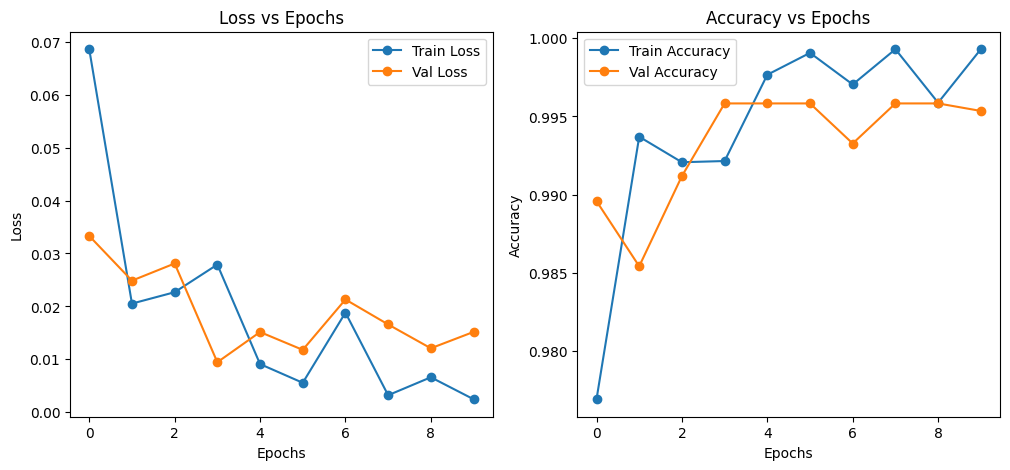

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Обучение на оригинальном датасете
train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs=10)

При 30 эпохах было заметно переобучение. Было принято решение оставить 10 эпох обучения ещё и по той причине, что обучение второй модели на аугментированном датасете слишком затратно по времени, но при сравнении было бы несправедливо устанавливать разное количество эпох и делать из этого какие-то выводы.

Epoch 0/9:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|██████████| 403/403 [03:31<00:00,  1.90it/s]

train Loss: 0.6764 Acc: 0.5804



100%|██████████| 45/45 [00:22<00:00,  1.99it/s]

val Loss: 0.6722 Acc: 0.5829
Epoch 1/9:



100%|██████████| 403/403 [03:30<00:00,  1.92it/s]

train Loss: 0.6760 Acc: 0.5817



100%|██████████| 45/45 [00:23<00:00,  1.95it/s]

val Loss: 0.6687 Acc: 0.5961
Epoch 2/9:



100%|██████████| 403/403 [03:30<00:00,  1.91it/s]

train Loss: 0.6757 Acc: 0.5803



100%|██████████| 45/45 [00:22<00:00,  1.99it/s]

val Loss: 0.6702 Acc: 0.6014
Epoch 3/9:



100%|██████████| 403/403 [03:29<00:00,  1.92it/s]

train Loss: 0.6761 Acc: 0.5762



100%|██████████| 45/45 [00:22<00:00,  2.04it/s]

val Loss: 0.6716 Acc: 0.5905
Epoch 4/9:



100%|██████████| 403/403 [03:30<00:00,  1.91it/s]

train Loss: 0.6750 Acc: 0.5838



100%|██████████| 45/45 [00:22<00:00,  1.96it/s]

val Loss: 0.6715 Acc: 0.5947
Epoch 5/9:



100%|██████████| 403/403 [03:30<00:00,  1.92it/s]

train Loss: 0.6767 Acc: 0.5807



100%|██████████| 45/45 [00:23<00:00,  1.95it/s]

val Loss: 0.6702 Acc: 0.5986
Epoch 6/9:



100%|██████████| 403/403 [03:29<00:00,  1.93it/s]

train Loss: 0.6765 Acc: 0.5740



100%|██████████| 45/45 [00:22<00:00,  2.04it/s]

val Loss: 0.6705 Acc: 0.5903
Epoch 7/9:



100%|██████████| 403/403 [03:30<00:00,  1.92it/s]

train Loss: 0.6760 Acc: 0.5748



100%|██████████| 45/45 [00:22<00:00,  1.96it/s]

val Loss: 0.6741 Acc: 0.5843
Epoch 8/9:



100%|██████████| 403/403 [03:29<00:00,  1.92it/s]

train Loss: 0.6779 Acc: 0.5757



100%|██████████| 45/45 [00:23<00:00,  1.93it/s]

val Loss: 0.6748 Acc: 0.5819
Epoch 9/9:



100%|██████████| 403/403 [03:30<00:00,  1.92it/s]

train Loss: 0.6753 Acc: 0.5756



100%|██████████| 45/45 [00:21<00:00,  2.06it/s]

val Loss: 0.6695 Acc: 0.5988


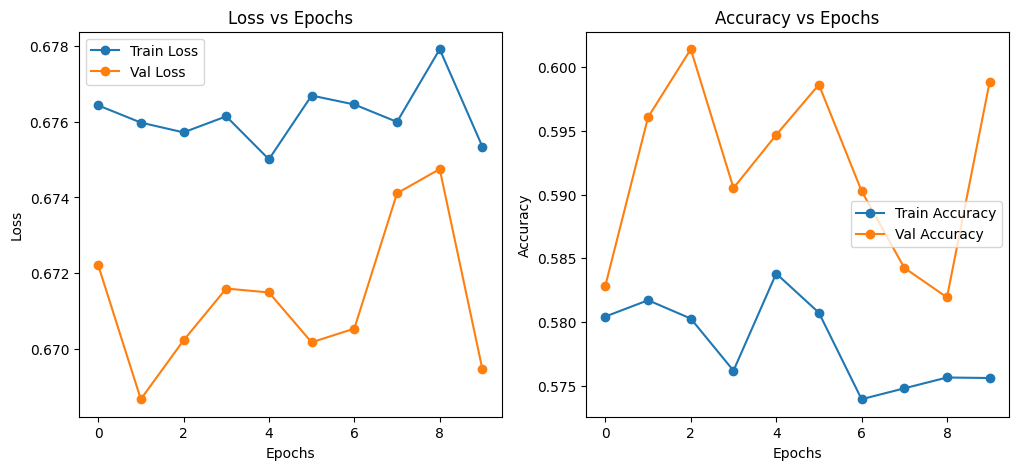

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Обучение на аугментированном датасете
train_model(aug_model, aug_train_loader, aug_val_loader, aug_loss, aug_optimizer, aug_scheduler, num_epochs=10)

Accuracy = 99.789%


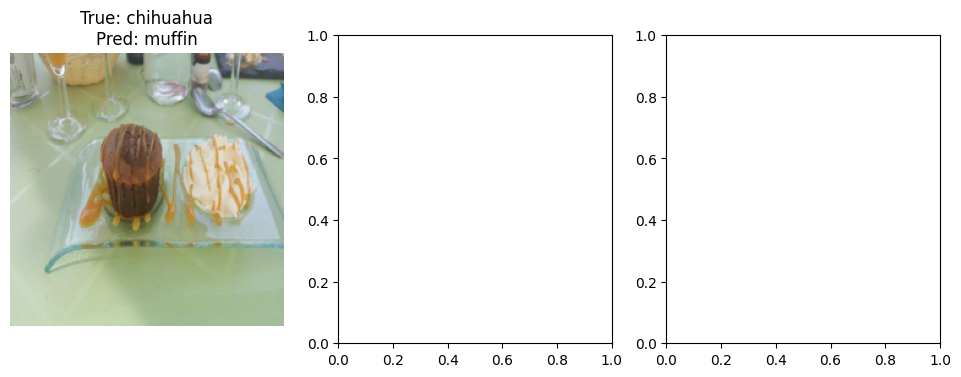

In [ ]:
show3mistakes(model,val_loader, val_size)

Видно, что модель, обученная на изначальных данных, ошиблась всего в одном случае, который оказался ошибкой разметки

Accuracy = 66.456%


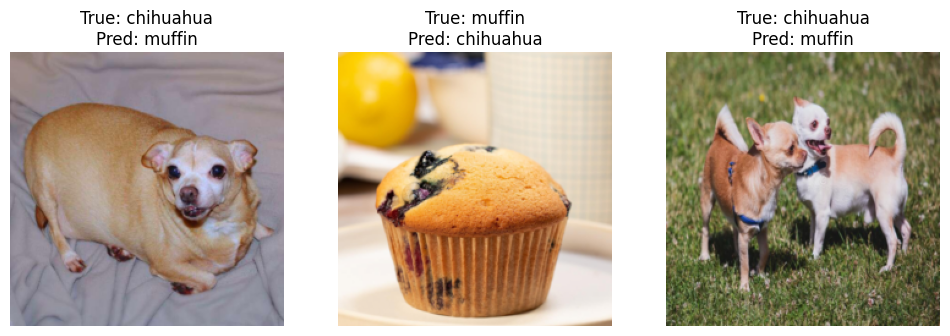

In [ ]:
show3mistakes(aug_model,val_loader, val_size)

Модель, обученная на аугментированном датасете, показала намного худшие результаты, что, вероятно связано с

а) недообучением: количество эпох для увеличенного датасета может быть недостаточно, но установить большее значение затруднительно в связи с ограничениями google colab на использование GPU.

б) слишком агрессивной аугментацией: возможно, аугментация слишком сильно искажает данные, из-за чего модель сложнее учится.

#Тестирование

In [ ]:
!unzip /content/drive/MyDrive/colab\ data/test.zip -d /content/test

Archive:  /content/drive/MyDrive/colab data/test.zip
   creating: /content/test/chihuahua/
  inflating: /content/test/chihuahua/img_4_971.jpg  
  inflating: /content/test/__MACOSX/chihuahua/._img_4_971.jpg  
  inflating: /content/test/chihuahua/img_1_1267.jpg  
  inflating: /content/test/__MACOSX/chihuahua/._img_1_1267.jpg  
  inflating: /content/test/chihuahua/img_1_149.jpg  
  inflating: /content/test/__MACOSX/chihuahua/._img_1_149.jpg  
  inflating: /content/test/chihuahua/img_0_414.jpg  
  inflating: /content/test/__MACOSX/chihuahua/._img_0_414.jpg  
  inflating: /content/test/chihuahua/img_0_819.jpg  
  inflating: /content/test/__MACOSX/chihuahua/._img_0_819.jpg  
  inflating: /content/test/chihuahua/img_2_511.jpg  
  inflating: /content/test/__MACOSX/chihuahua/._img_2_511.jpg  
  inflating: /content/test/chihuahua/img_0_1071.jpg  
  inflating: /content/test/__MACOSX/chihuahua/._img_0_1071.jpg  
  inflating: /content/test/chihuahua/img_1_15.jpg  
  inflating: /content/test/__MACOS

In [ ]:
def test_model(model, loader, dataset_size):
  correct = 0
  wrong_preds = []

  with torch.no_grad():
    for inputs, labels in loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
        for i in range(len(labels)):
            if preds_class[i] != labels[i]:
                wrong_preds.append((inputs[i].cpu(), labels[i].item(), preds_class[i].item()))

        correct += (preds_class == labels).sum().item()

  accuracy = correct / dataset_size * 100
  print(f"Accuracy = {accuracy:.3f}%")
  return wrong_preds

In [ ]:
test_dataset = datasets.ImageFolder(root="/content/test", transform=resize_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Accuracy = 99.493%


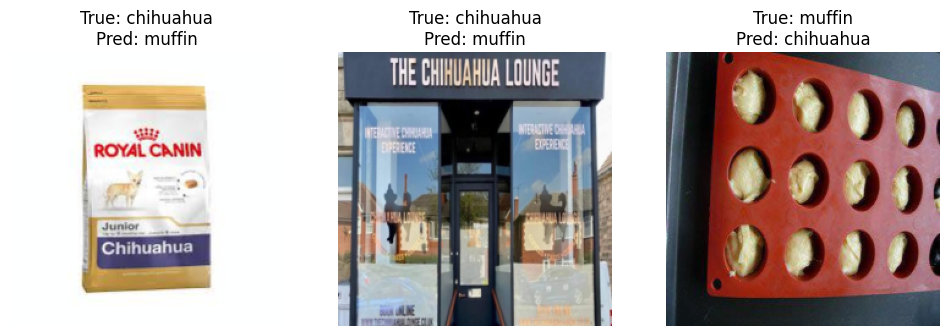

In [ ]:
show3mistakes(model,test_loader, len(test_dataset))

Accuracy = 62.922%


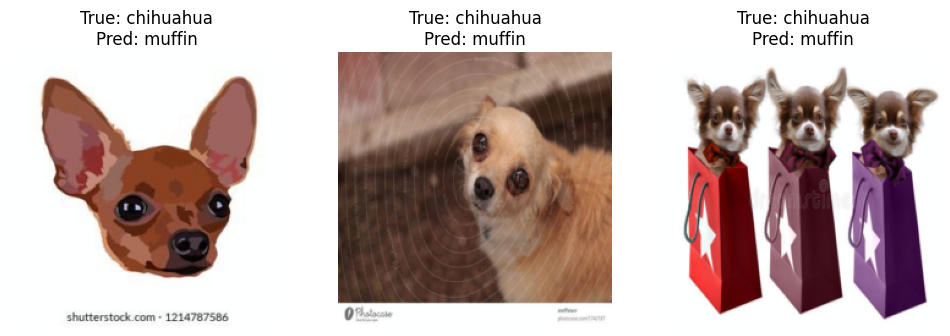

In [ ]:
show3mistakes(aug_model,test_loader, len(test_dataset))

Итоговая точность для модели, обученной на изначальном датасете = 99.493%

Итоговая точность для модели, обученной на аугментированном датасете = 62.922%

(улучшения качества удалось достигнуть для модели 1 (model) с помощью уменьшения количества эпох обучения с 30 до 10, о чём писалось выше)